In [2]:
import pandas as pd
from matplotlib.pylab import plt
import numpy as np
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [3]:
df = pd.read_csv("../WELFake_Dataset_processed.csv")

In [4]:
#Removing all of the NaN values
df.head(5)

,Unnamed: 0,title,text,label,all
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,1,NaN,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?
2,2,UNBELIEVABLE! OBAMAS ATTORNEY GENERAL SAYS MOS...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMAS ATTORNEY GENERAL SAYS MOS...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,4,SATAN : Russia unvelis an image of its terrify...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN : Russia unvelis an image of its terrify...


In [5]:
print(f'Ratio of news')
print(df.label.value_counts(normalize = True).rename({1:'Reliable',0:'Fake'}))

Ratio of news
Reliable    0.514404
Fake        0.485596
Name: label, dtype: float64


In [6]:
df = df.drop(['Unnamed: 0'],axis = 1)
df = df.fillna(' ')
df.head()

,title,text,label,all
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?
2,UNBELIEVABLE! OBAMAS ATTORNEY GENERAL SAYS MOS...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMAS ATTORNEY GENERAL SAYS MOS...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN : Russia unvelis an image of its terrify...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN : Russia unvelis an image of its terrify...


In [7]:
df["all"] = df['title'] + df['text']
df["length"] = df["all"].apply(lambda x : len(x) - x.count(" "))

In [8]:
fake_lengths = df[df["label"] == 1]["length"]
real_lengths = df[df['label'] == 0]["length"]

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         2.,  1.,  5., 12.,  8., 10.,  8.,  7., 11., 15., 19., 17., 21.,
        22., 13., 15.,  7.,  9.,  4.,  9.,  2.,  3.,  6.,  3.,  4.,  3.]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.58974359, 148.71794872, 153.84615385, 158.97435897,
        164.1025641 , 169.23076923, 174.35897436, 179.48717949,
        184.61538462, 189.74358974, 194.87179487, 200.        ]),
 <BarContainer object of 39 artists>)

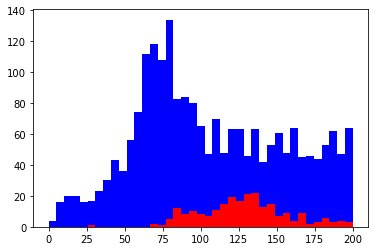

In [9]:
bins = np.linspace(0, 200, 40)
plt.hist(fake_lengths,bins,label = 'Fake',color = 'blue')
plt.hist(real_lengths,bins,label = 'Reliable',color = 'red')

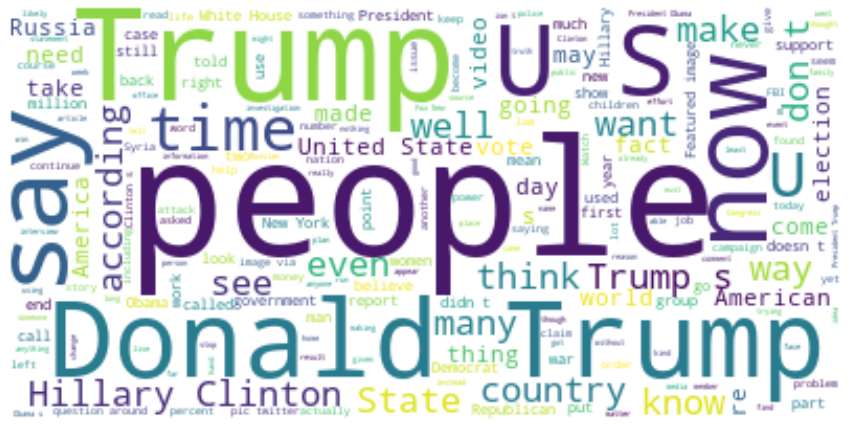

In [10]:
#Reliable news word cloud
text = " ".join(sentence for sentence in df[df['label'] == 1]['all'])
stopwords = set(STOPWORDS)
st = set(['said','one','will'])
stopwords = stopwords.union(st)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

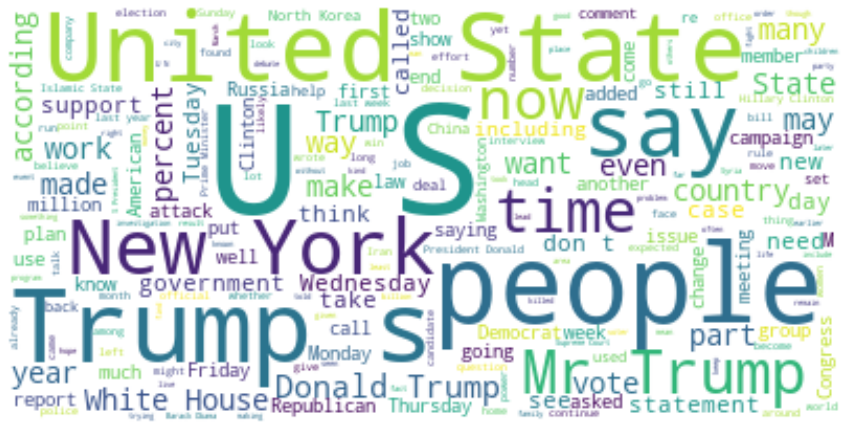

In [11]:
#Fake news word cloud
text = " ".join(sentence for sentence in df[df['label'] == 0]['all'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
from sklearn.model_selection import train_test_split
#Splitting training and testing data
train_labels = df['label']
x_train,x_test,y_train,y_test = train_test_split(df["all"],train_labels,test_size = 0.4)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words = 'english', max_df = 0.7)
tfidf_train = tfidf.fit_transform(x_train) 
tfidf_test = tfidf.transform(x_test)

In [42]:
#Creating a batch generator

def _data_generator(x, y, batch_size):
    num_samples = x.shape[0]
    num_batches = num_samples // batch_size
    if num_samples % batch_size:
        num_batches += 1

    while 1:
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            yield x_batch, y_batch

In [43]:
#Creating a training / testing generator
batch_size = 1000
train_generator = _data_generator(
    tfidf_train, y_train, batch_size)
validation_generator = _data_generator(
    tfidf_test, y_test, batch_size)
steps_epoch = tfidf_train.shape[0]//batch_size
if tfidf_train.shape[0] % batch_size:
    steps_epoch += 1

# Get number of validation steps.
validation_steps = tfidf_test.shape[0] // batch_size
if tfidf_test.shape[0] % batch_size:
    validation_steps += 1

from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(random_state=123)
nb_epochs = 10
for k in range(nb_epochs):
    for i in range(steps_epoch):
        x_batch,y_batch = next(train_generator)
        classifier.partial_fit(x_batch, y_batch, classes=np.unique(df['label']))
        
    

In [45]:
from sklearn.metrics import accuracy_score


Y_test_preds = []
for j in range(tfidf_test.shape[0]): ## Looping through test batches for making predictions
    Y_preds = classifier.predict(tfidf_test[j])
    Y_test_preds.append(Y_preds.tolist())

print("Test Accuracy      : {}".format(accuracy_score(y_test, Y_test_preds)))

Test Accuracy      : 0.9406668052956263


MultinomialNB()

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14034
           1       0.91      0.88      0.89     14820

    accuracy                           0.89     28854
   macro avg       0.89      0.89      0.89     28854
weighted avg       0.89      0.89      0.89     28854

